In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [ ]:
#!unzip "annotations.zip" -d "sartorius/"

## Visualizing Images

In [ ]:
dataDir=Path('/content/sartorius')
annFile = Path('/content/sartorius/annotations_all.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds[-3:])

In [ ]:
imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = io.imread(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

# Training


In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.evaluation.evaluator import DatasetEvaluator
setup_logger()

<Logger detectron2 (DEBUG)>

# Loading coco formatted data

In [ ]:
dataDir=Path('sartorius')
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances('sartorius_train',{}, 'sartorius/fold_1_train.json', dataDir)
register_coco_instances('sartorius_val',{},'sartorius/fold_1_val.json', dataDir)
metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')

[12/30 13:06:55 d2.data.datasets.coco]: Loading sartorius/fold_1_train.json takes 1.86 seconds.
[12/30 13:06:55 d2.data.datasets.coco]: Loaded 484 images in COCO format from sartorius/fold_1_train.json


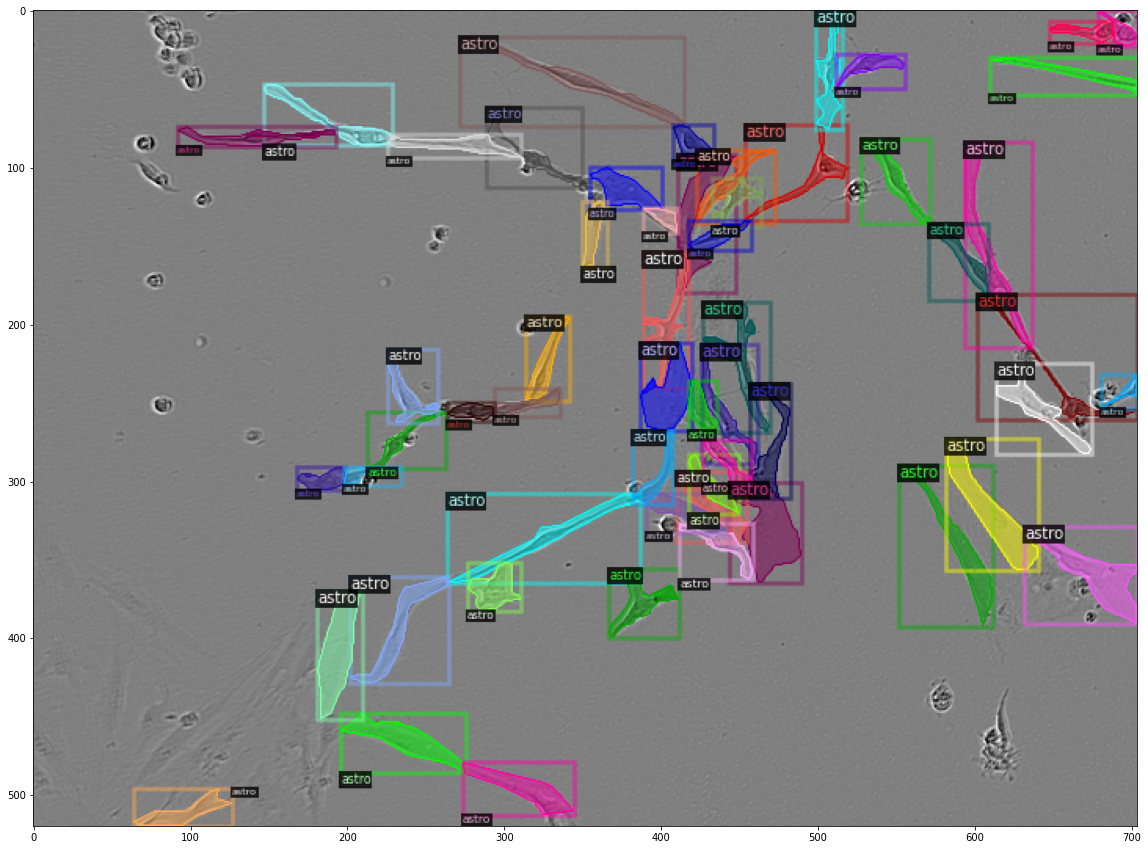

In [ ]:
#Display a sample file to check the data is loaded correctly

d = train_ds[42]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

# Define evaluator
Generates lines like this in the training output: [10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311

In [ ]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

#Saving model with best MAP IOU score
    
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

    def build_hooks(self):

        # copy of cfg
        cfg = self.cfg.clone()

        # build the original model hooks
        hooks = super().build_hooks()

        # add the best checkpointer hook to save best model
        hooks.insert(-1, BestCheckpointer(cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                                         "MaP IoU",
                                         "max",
                                         ))
        return hooks    

In [ ]:
#Training

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "model_live.pth"  # Initialzed from own pretrained model on live cell dataset
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0005 
cfg.SOLVER.MAX_ITER = 10000   
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.SOLVER.WARMUP_ITERS = 400 
cfg.SOLVER.MOMENTUM = 0.9
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5
cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch
cfg.SOLVER.CHECKPOINT_PERIOD = cfg.SOLVER.MAX_ITER+1



os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/30 13:06:56 d2.data.datasets.coco]: Loaded 484 images in COCO format from sartorius/fold_1_train.json
[12/30 13:07:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3

/opt/conda/lib/python3.8/site-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:181.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/opt/conda/lib/python3.8/site-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to

[12/30 13:07:28 d2.utils.events]:  eta: 1:09:14  iter: 19  total_loss: 1.351  loss_cls: 0.2609  loss_box_reg: 0.5497  loss_mask: 0.3026  loss_rpn_cls: 0.04924  loss_rpn_loc: 0.186  time: 0.8953  data_time: 0.4804  lr: 0.00024133  max_mem: 5162M
[12/30 13:07:54 d2.utils.events]:  eta: 1:14:37  iter: 39  total_loss: 1.454  loss_cls: 0.3023  loss_box_reg: 0.5158  loss_mask: 0.2988  loss_rpn_cls: 0.09116  loss_rpn_loc: 0.2081  time: 1.1177  data_time: 0.8708  lr: 0.00049009  max_mem: 5162M
[12/30 13:08:11 d2.utils.events]:  eta: 1:14:29  iter: 59  total_loss: 1.465  loss_cls: 0.3735  loss_box_reg: 0.5193  loss_mask: 0.2983  loss_rpn_cls: 0.07108  loss_rpn_loc: 0.1898  time: 1.0263  data_time: 0.4212  lr: 0.00073885  max_mem: 5162M
[12/30 13:08:34 d2.utils.events]:  eta: 1:16:11  iter: 79  total_loss: 1.365  loss_cls: 0.3034  loss_box_reg: 0.4666  loss_mask: 0.2894  loss_rpn_cls: 0.07341  loss_rpn_loc: 0.208  time: 1.0532  data_time: 0.6857  lr: 0.00098762  max_mem: 5162M
[12/30 13:09:00 d2

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('sartorius_val')
outs = []
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('sartorius_train'), 
                    
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('sartorius_train'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(40,45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])

## Evaluation metrics

In [ ]:
#import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("sartorius_val", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "sartorius_val")

#Use the created predicted model in the previous step
r = inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [12/29 03:01:14 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/29 03:01:15 d2.data.datasets.coco]: Loaded 121 images in COCO format from sartorius/annotations_val.json
[12/29 03:01:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/29 03:01:15 d2.data.common]: Serializing 121 elements to byte tensors and concatenating them all ...
[12/29 03:01:15 d2.data.common]: Serialized dataset takes 1.72 MiB
[12/29 03:01:15 d2.evaluation.evaluator]: Start inference on 121 batches
[12/29 03:01:17 d2.evaluation.evaluator]: Inference done 11/121. Dataloading: 0.0014 s/iter. Inference: 0.0758 s/iter. Eval: 0.0220 s/iter. Total: 0.0993 s/iter. ETA=0:00:10
[12/29 03:01:22 d2.evaluation.evaluator]: Inference done 51/121. Dataloading: 0.0021 s/iter. Inference: 0.0845 s/iter. Eval